## Stage 1: import dataset + libraries

In [35]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from data import Preprocessing, FeatureExtraction
from models.dimension_reduction import PCA, WordEmbeddingVectors

In [36]:
prepro_tool = Preprocessing()
train_df = prepro_tool.read_CSV(file_name='train.csv')
test_df = prepro_tool.read_CSV(file_name='test.csv')

train_df.shape, test_df.shape

✓ 'punkt' is already available.
✓ 'stopwords' is already available.
✗ 'wordnet' not found. Downloading...
✓ 'averaged_perceptron_tagger' is already available.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tranquochieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((27480, 10), (3534, 9))

## Stage 2: Preprocessing

In [37]:
train_df['token'] = train_df['text'].apply(prepro_tool.tokenize_preprocessing)
test_df['token'] = test_df['text'].apply(prepro_tool.tokenize_preprocessing)

In [38]:
word_emb_model = WordEmbeddingVectors()

X_train_feature = word_emb_model.vectorize(train_df['token'])
X_test_feature = word_emb_model.vectorize(test_df['token'])

X_train_feature.shape

/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/.DS_Store
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/test.csv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/fasttext_subwords_300.kv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/train.csv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/fasttext_subwords_300.kv.vectors.npy
Loader model successfully ! Vector size: 300


(27480, 300)

In [39]:
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

train_data[0]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Kmï¿½)': 652860.0,
 'Density (P/Kmï¿½)': 60,
 'token': ['id', 'responded', 'going'],
 '__index_level_0__': 0}

In [40]:
train_data = train_data.map(lambda ex: {'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })
test_data = test_data.map(lambda ex: {'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })

train_data[0]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Kmï¿½)': 652860.0,
 'Density (P/Kmï¿½)': 60,
 'token': ['id', 'responded', 'going'],
 '__index_level_0__': 0,
 'label': 1}

### Load number of samples for each class

/var/folders/cy/hxjg9r351_99ytx8k04pq_4c0000gn/T/ipykernel_10930/3149057442.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


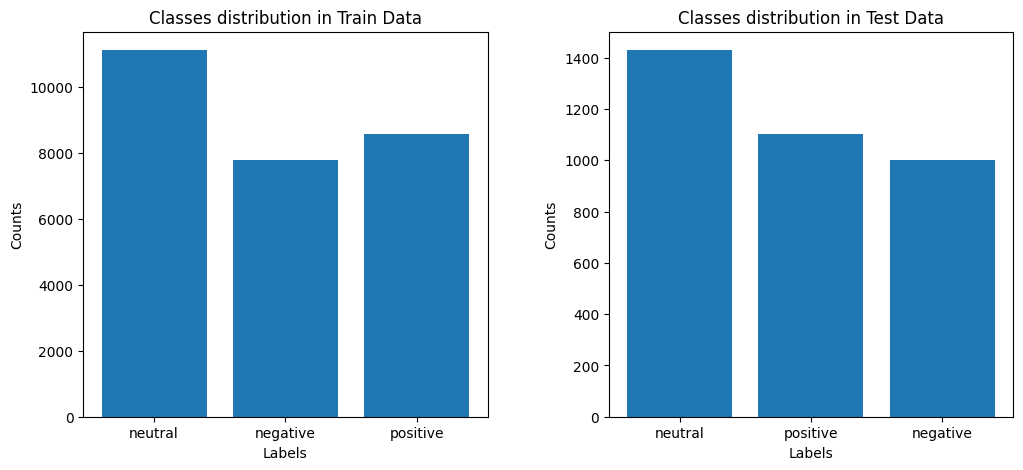

In [41]:
from typing import Counter
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

counter = Counter(train_data['sentiment'])
axs[0].bar(counter.keys(), counter.values())
axs[0].set_title("Classes distribution in Train Data")
axs[0].set_xlabel("Labels")
axs[0].set_ylabel("Counts")

counter = Counter(test_data['sentiment'])
axs[1].bar(counter.keys(), counter.values())
axs[1].set_title("Classes distribution in Test Data")
axs[1].set_xlabel("Labels")
axs[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

In [ ]:
pca = PCA()
pca.fit_by_amount_of_variance(X_train_feature, threshold=0.60)
X_train_pca = pca.transform(X_train_feature)
X_test_pca = pca.transform(X_test_feature)
X_train_pca.shape, X_test_pca.shape

PCA keep 30 components correponding to keep 0.6041049003758305 of total variance


((27480, 30), (3534, 30))

In [43]:
def add_word_emb(example, idx, word_emb_feature):
    return {'word_emb': word_emb_feature[idx]}

train_data = train_data.map(add_word_emb, with_indices=True, fn_kwargs={'word_emb_feature': X_train_pca})
test_data = test_data.map(add_word_emb, with_indices=True, fn_kwargs={'word_emb_feature': X_test_pca})
train_data[0].keys()

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

dict_keys(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Kmï¿½)', 'Density (P/Kmï¿½)', 'token', '__index_level_0__', 'label', 'word_emb'])

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
train_data.set_format(type="torch", columns=['word_emb', 'label'])
test_data.set_format(type="torch", columns=['word_emb', 'label'])
train_data[0]

device: cpu


{'label': tensor(1),
 'word_emb': tensor([ 0.1231,  0.0248,  0.1189,  0.0016,  0.0135,  0.1539, -0.0836,  0.0122,
         -0.0189,  0.0266,  0.0422,  0.0041,  0.0324, -0.0204,  0.0044, -0.0589,
          0.0452,  0.0247,  0.1445, -0.0218,  0.0637,  0.0653,  0.0128,  0.0498,
         -0.0294, -0.0298,  0.0244,  0.0135, -0.0036, -0.0146])}

### Split data into train and valid set

In [45]:
train_dict = Dataset.train_test_split(train_data, test_size=0.2, shuffle=True, seed=2025)
train_data = train_dict['train']
valid_data = train_dict['test']

train_data.shape, valid_data.shape, test_data.shape

((21984, 14), (5496, 14), (3534, 13))

## Step 3: Build Model

- We build a simple Logistic Regression model using neural network block from **torch**.

In [46]:
class LogisticReg(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):       # X shape: (N, input_size) => (N, output_size)
        X = self.fc(X)
        X = self.relu(X)
        return self.softmax(X)

## Step 4: Training model

### Define model hyperparameter

In [47]:
learning_rate = 5e-3
batch_size = 64
num_epochs = 100
stop_iter = 5

### Load data into batch

In [48]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

len(train_loader), len(valid_loader), len(test_loader)

(344, 86, 56)

In [49]:
input_size = list(train_data[0]['word_emb'].size())[0]
output_size = 3

torch.manual_seed(2025)
model = LogisticReg(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()
model.to(device)

LogisticReg(
  (fc): Linear(in_features=30, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [50]:
def train_fn(model, loader, epoch, show_progress=False):
    model.train()
    epoch_loss = 0
    progress = tqdm(loader, desc=f"Epoch {epoch} training") if show_progress else loader
    for batch in progress:
        input = batch['word_emb'].to(device)
        label = batch['label'].to(device)
        output = model(input)

        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss
    
    print(f"Train loss at epoch {epoch}: {(epoch_loss / len(loader)):.3f}\n---")
    return epoch_loss / len(loader)


def accuracy_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)


def f1_score_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return f1_score(labels, predictions, average='weighted')


def evaluate_fn(model, loader, name, returned_predictions=False, show_progress=False):
    """
    if returned_predictions is True, return the predictions and labels
    else return the accuracy and f1 score
    """
    model.eval()
    valid_loss = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        progress = tqdm(loader, desc=f"Evaluating on {name.lower()} data") if show_progress else loader
        for batch in progress:
            input = batch['word_emb'].to(device)
            label = batch['label'].to(device)
            output = model(input)

            loss = criteria(output, label)
            valid_loss += loss

            all_outputs.extend(output.detach().cpu().numpy())
            all_labels.extend(label.detach().cpu().numpy())
    
    if returned_predictions:
        return np.array(all_outputs), np.array(all_labels)
        
    acc_score = accuracy_eval(all_outputs, all_labels)
    f1_score = f1_score_eval(all_outputs, all_labels)
    print(f"{name} loss: {(valid_loss / len(loader)):.3f} | {name} accuracy: {acc_score:.3f} | {name} F1-score: {f1_score:.3f}\n---\n")
    return acc_score, f1_score

In [51]:
best_score = float("-inf")
patient = 3

train_losses = []
valid_acc_scores = []

for epoch in range(num_epochs):
    train_loss = train_fn(model, train_loader, epoch+1, show_progress=True)
    acc_score, _ = evaluate_fn(model, valid_loader, "Valid")

    train_losses.append(train_loss)
    valid_acc_scores.append(acc_score)

    if acc_score > best_score:
        best_score = acc_score
        torch.save(model.state_dict(), "ME-model.pt")
        patient = 3
        print(f"Save model successfully")
    else:
        patient -= 1
        if patient <= 0:
            print(f"Early stopping at epoch: {epoch}")
            break

Epoch 1 training: 100%|██████████| 344/344 [00:02<00:00, 151.94it/s]


Train loss at epoch 1: 1.075
---
Valid loss: 1.048 | Valid accuracy: 0.500 | Valid F1-score: 0.405
---

Save model successfully


Epoch 2 training: 100%|██████████| 344/344 [00:01<00:00, 194.93it/s]


Train loss at epoch 2: 1.038
---
Valid loss: 1.023 | Valid accuracy: 0.532 | Valid F1-score: 0.448
---

Save model successfully


Epoch 3 training: 100%|██████████| 344/344 [00:02<00:00, 165.61it/s]


Train loss at epoch 3: 1.020
---
Valid loss: 1.009 | Valid accuracy: 0.539 | Valid F1-score: 0.460
---

Save model successfully


Epoch 4 training: 100%|██████████| 344/344 [00:02<00:00, 160.64it/s]


Train loss at epoch 4: 1.009
---
Valid loss: 0.999 | Valid accuracy: 0.544 | Valid F1-score: 0.469
---

Save model successfully


Epoch 5 training: 100%|██████████| 344/344 [00:01<00:00, 197.70it/s]


Train loss at epoch 5: 1.001
---
Valid loss: 0.992 | Valid accuracy: 0.551 | Valid F1-score: 0.481
---

Save model successfully


Epoch 6 training: 100%|██████████| 344/344 [00:01<00:00, 188.83it/s]


Train loss at epoch 6: 0.995
---
Valid loss: 0.987 | Valid accuracy: 0.558 | Valid F1-score: 0.494
---

Save model successfully


Epoch 7 training: 100%|██████████| 344/344 [00:01<00:00, 179.15it/s]


Train loss at epoch 7: 0.990
---
Valid loss: 0.984 | Valid accuracy: 0.563 | Valid F1-score: 0.506
---

Save model successfully


Epoch 8 training: 100%|██████████| 344/344 [00:01<00:00, 173.45it/s]


Train loss at epoch 8: 0.987
---
Valid loss: 0.980 | Valid accuracy: 0.567 | Valid F1-score: 0.514
---

Save model successfully


Epoch 9 training: 100%|██████████| 344/344 [00:01<00:00, 173.48it/s]


Train loss at epoch 9: 0.984
---
Valid loss: 0.977 | Valid accuracy: 0.573 | Valid F1-score: 0.524
---

Save model successfully


Epoch 10 training: 100%|██████████| 344/344 [00:01<00:00, 186.48it/s]


Train loss at epoch 10: 0.981
---
Valid loss: 0.975 | Valid accuracy: 0.575 | Valid F1-score: 0.529
---

Save model successfully


Epoch 11 training: 100%|██████████| 344/344 [00:01<00:00, 189.01it/s]


Train loss at epoch 11: 0.979
---
Valid loss: 0.973 | Valid accuracy: 0.579 | Valid F1-score: 0.537
---

Save model successfully


Epoch 12 training: 100%|██████████| 344/344 [00:01<00:00, 177.32it/s]


Train loss at epoch 12: 0.977
---
Valid loss: 0.971 | Valid accuracy: 0.584 | Valid F1-score: 0.545
---

Save model successfully


Epoch 13 training: 100%|██████████| 344/344 [00:01<00:00, 176.25it/s]


Train loss at epoch 13: 0.975
---
Valid loss: 0.970 | Valid accuracy: 0.585 | Valid F1-score: 0.548
---

Save model successfully


Epoch 14 training: 100%|██████████| 344/344 [00:02<00:00, 162.72it/s]


Train loss at epoch 14: 0.974
---
Valid loss: 0.969 | Valid accuracy: 0.587 | Valid F1-score: 0.553
---

Save model successfully


Epoch 15 training: 100%|██████████| 344/344 [00:01<00:00, 176.04it/s]


Train loss at epoch 15: 0.972
---
Valid loss: 0.968 | Valid accuracy: 0.589 | Valid F1-score: 0.557
---

Save model successfully


Epoch 16 training: 100%|██████████| 344/344 [00:01<00:00, 194.50it/s]


Train loss at epoch 16: 0.971
---
Valid loss: 0.967 | Valid accuracy: 0.593 | Valid F1-score: 0.563
---

Save model successfully


Epoch 17 training: 100%|██████████| 344/344 [00:01<00:00, 217.54it/s]


Train loss at epoch 17: 0.970
---
Valid loss: 0.966 | Valid accuracy: 0.595 | Valid F1-score: 0.567
---

Save model successfully


Epoch 18 training: 100%|██████████| 344/344 [00:01<00:00, 198.74it/s]


Train loss at epoch 18: 0.969
---
Valid loss: 0.965 | Valid accuracy: 0.598 | Valid F1-score: 0.572
---

Save model successfully


Epoch 19 training: 100%|██████████| 344/344 [00:01<00:00, 203.09it/s]


Train loss at epoch 19: 0.968
---
Valid loss: 0.964 | Valid accuracy: 0.598 | Valid F1-score: 0.572
---



Epoch 20 training: 100%|██████████| 344/344 [00:01<00:00, 191.87it/s]


Train loss at epoch 20: 0.967
---
Valid loss: 0.964 | Valid accuracy: 0.600 | Valid F1-score: 0.576
---

Save model successfully


Epoch 21 training: 100%|██████████| 344/344 [00:01<00:00, 212.95it/s]


Train loss at epoch 21: 0.967
---
Valid loss: 0.963 | Valid accuracy: 0.600 | Valid F1-score: 0.578
---

Save model successfully


Epoch 22 training: 100%|██████████| 344/344 [00:01<00:00, 201.20it/s]


Train loss at epoch 22: 0.966
---
Valid loss: 0.963 | Valid accuracy: 0.601 | Valid F1-score: 0.579
---

Save model successfully


Epoch 23 training: 100%|██████████| 344/344 [00:01<00:00, 180.91it/s]


Train loss at epoch 23: 0.966
---
Valid loss: 0.962 | Valid accuracy: 0.602 | Valid F1-score: 0.581
---

Save model successfully


Epoch 24 training: 100%|██████████| 344/344 [00:01<00:00, 173.58it/s]


Train loss at epoch 24: 0.965
---
Valid loss: 0.962 | Valid accuracy: 0.602 | Valid F1-score: 0.582
---



Epoch 25 training: 100%|██████████| 344/344 [00:02<00:00, 153.06it/s]


Train loss at epoch 25: 0.964
---
Valid loss: 0.961 | Valid accuracy: 0.603 | Valid F1-score: 0.583
---

Save model successfully


Epoch 26 training: 100%|██████████| 344/344 [00:01<00:00, 195.96it/s]


Train loss at epoch 26: 0.964
---
Valid loss: 0.961 | Valid accuracy: 0.604 | Valid F1-score: 0.585
---

Save model successfully


Epoch 27 training: 100%|██████████| 344/344 [00:02<00:00, 167.14it/s]


Train loss at epoch 27: 0.963
---
Valid loss: 0.961 | Valid accuracy: 0.605 | Valid F1-score: 0.586
---

Save model successfully


Epoch 28 training: 100%|██████████| 344/344 [00:01<00:00, 202.41it/s]


Train loss at epoch 28: 0.963
---
Valid loss: 0.960 | Valid accuracy: 0.606 | Valid F1-score: 0.589
---

Save model successfully


Epoch 29 training: 100%|██████████| 344/344 [00:01<00:00, 212.31it/s]


Train loss at epoch 29: 0.963
---
Valid loss: 0.960 | Valid accuracy: 0.607 | Valid F1-score: 0.590
---

Save model successfully


Epoch 30 training: 100%|██████████| 344/344 [00:02<00:00, 159.87it/s]


Train loss at epoch 30: 0.962
---
Valid loss: 0.960 | Valid accuracy: 0.605 | Valid F1-score: 0.589
---



Epoch 31 training: 100%|██████████| 344/344 [00:01<00:00, 210.72it/s]


Train loss at epoch 31: 0.962
---
Valid loss: 0.959 | Valid accuracy: 0.608 | Valid F1-score: 0.592
---

Save model successfully


Epoch 32 training: 100%|██████████| 344/344 [00:01<00:00, 183.40it/s]


Train loss at epoch 32: 0.962
---
Valid loss: 0.959 | Valid accuracy: 0.608 | Valid F1-score: 0.593
---

Save model successfully


Epoch 33 training: 100%|██████████| 344/344 [00:02<00:00, 130.22it/s]


Train loss at epoch 33: 0.961
---
Valid loss: 0.959 | Valid accuracy: 0.609 | Valid F1-score: 0.594
---

Save model successfully


Epoch 34 training: 100%|██████████| 344/344 [00:02<00:00, 150.67it/s]


Train loss at epoch 34: 0.961
---
Valid loss: 0.959 | Valid accuracy: 0.608 | Valid F1-score: 0.593
---



Epoch 35 training: 100%|██████████| 344/344 [00:01<00:00, 211.79it/s]


Train loss at epoch 35: 0.961
---
Valid loss: 0.959 | Valid accuracy: 0.609 | Valid F1-score: 0.595
---



Epoch 36 training: 100%|██████████| 344/344 [00:01<00:00, 216.10it/s]


Train loss at epoch 36: 0.961
---
Valid loss: 0.958 | Valid accuracy: 0.609 | Valid F1-score: 0.596
---

Early stopping at epoch: 35


## Step 4: Model evaluation

### Load best model

In [58]:
model.load_state_dict(torch.load("ME-model.pt", weights_only=True))

<All keys matched successfully>

### Compute accuracy & F1-Score

In [59]:
evaluate_fn(model, test_loader, "Test")

Test loss: 0.956 | Test accuracy: 0.603 | Test F1-score: 0.590
---



(0.6032823995472553, 0.5895883059204081)

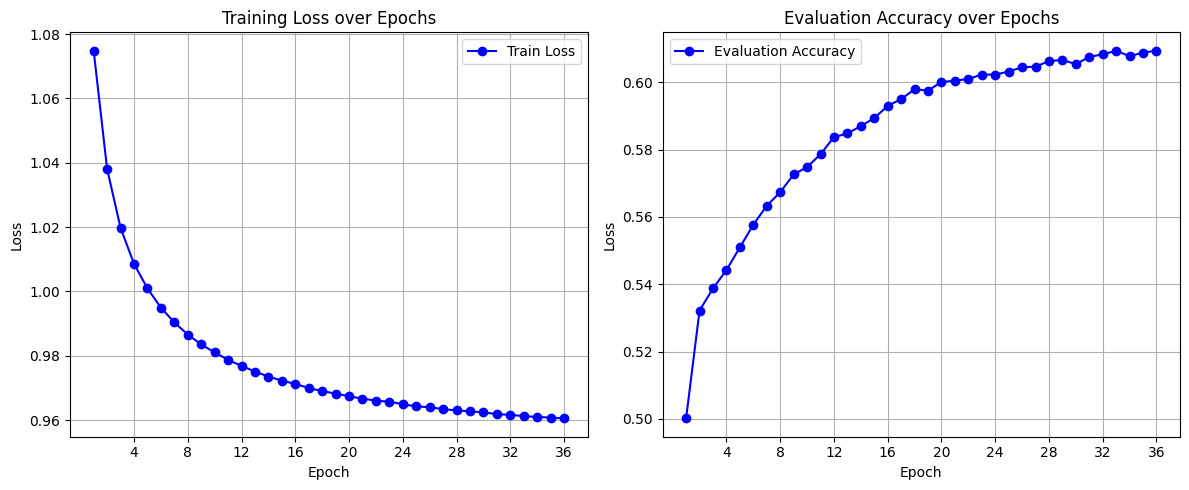

In [61]:
epochs = list(range(1, len(train_losses)+1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss over Epochs")
axes[0].grid(True)
axes[0].legend()
axes[0].set_xticks([epoch for epoch in epochs if epoch % 4 == 0])

axes[1].plot(epochs, valid_acc_scores, marker='o', linestyle='-', color='b', label='Evaluation Accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Evaluation Accuracy over Epochs")
axes[1].grid(True)
axes[1].legend()
axes[1].set_xticks([epoch for epoch in epochs if epoch % 4 == 0])

plt.tight_layout()
plt.show()

### Draw AUC - ROC curves

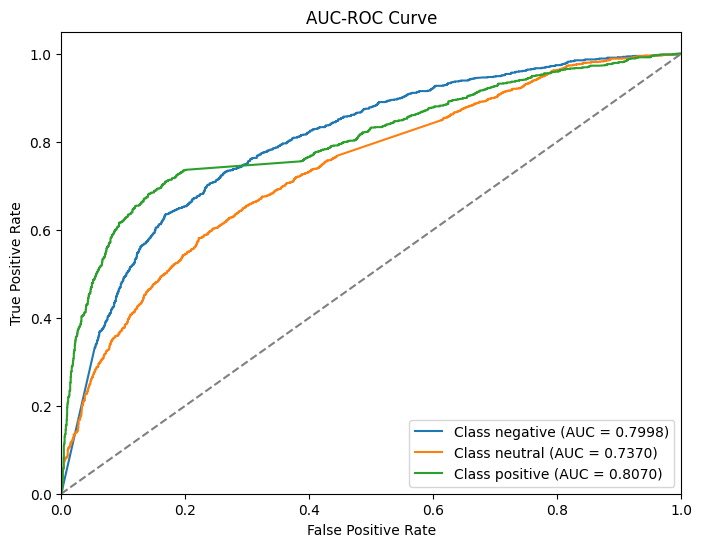

In [62]:
from visualization import plot_roc_auc, plot_confusion_matrix

y_prob, y_true = evaluate_fn(model, test_loader, "Test", returned_predictions=True)
y_pred = np.argmax(y_prob, axis=1)
y_prob.shape, y_true.shape, y_pred.shape

plot_roc_auc(y_true, y_prob, classes=['negative', 'neutral', 'positive'])

### Plot confusion matrix

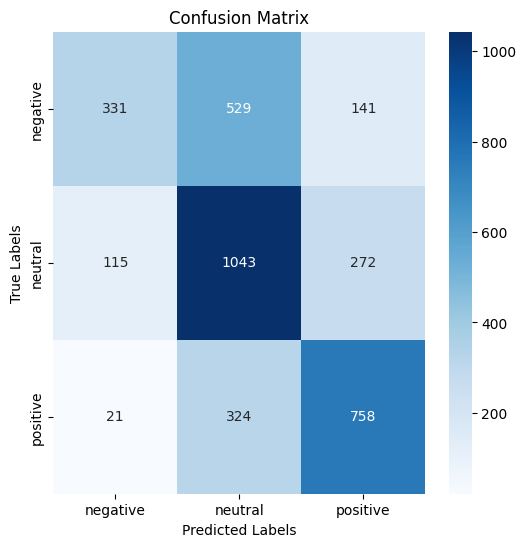

In [63]:
plot_confusion_matrix(y_true, y_pred, class_labels=['negative', 'neutral', 'positive'])